# Superdense Coding

In [1]:
# Importing everything
from qiskit import QuantumCircuit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

We saw that to create an entangled pair, we needed to do a H-gate followed by a CNOT. Let's create a function that takes a `QuantumCircuit` and entangles the qubits with indices `a` and `b`:

In [2]:
# Define a function that takes a QuantumCircuit (qc) 
# and two integers (a & b)
def create_bell_pair(qc, a, b):
    qc.h(a) # Apply a h-gate to the first qubit
    qc.cx(a,b) # Apply a CNOT, using the first qubit as the control

Next we need to encode our message. We saw that there were four possible messages we could send: `00`, `10`, `01` or `11`. Let's create a function that takes this message and applies the appropriate gates for us:

In [3]:
# Define a function that takes a QuantumCircuit (qc)
# a qubit index (qubit) and a message string (msg)
def encode_message(qc, qubit, msg):
    if msg == "00":
        pass    # To send 00 we do nothing
    elif msg == "10":
        qc.x(qubit) # To send 10 we apply an X-gate
    elif msg == "01":
        qc.z(qubit) # To send 01 we apply a Z-gate
    elif msg == "11":
        qc.z(qubit) # To send 11, we apply a Z-gate
        qc.x(qubit) # followed by an X-gate
    else:
        print("Invalid Message: Sending '00'")

Finally, we need to decode our message, we saw we could do this using a CNOT followed by a H-gate. Let's create a function that does this for us too:

In [4]:
def decode_message(qc, a, b):
    qc.cx(a,b)
    qc.h(a)

Finally, we can put this together to complete our protocol.

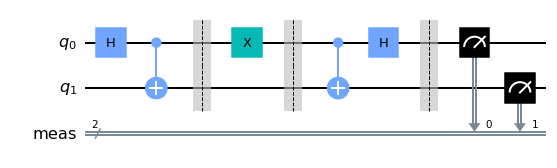

In [5]:
# Create the quantum circuit with 2 qubits
qc = QuantumCircuit(2)


# First, Charlie creates the entangled pair between Alice and Bob
create_bell_pair(qc, 0, 1)
qc.barrier() # This adds a barrier to our circuit. A barrier 
             # separates the gates in our diagram and makes it 
             # clear which part of the circuit is which

# At this point, qubit 0 goes to Alice and qubit 1 goes to Bob

# Next, Alice encodes her message onto qubit 0. In this case,
# we want to send the message '10'. You can try changing this
# value and see how it affects the circuit
message = "10"
encode_message(qc, 0, message)
qc.barrier()
# Alice then sends her qubit to Bob.

# After recieving qubit 0, Bob applies the recovery protocol:
decode_message(qc, 0, 1)

# Finally, Bob measures his qubits to read Alice's message
qc.measure_all()

# Draw our output
qc.draw()

## 4. Superdense Coding on a Real Quantum Computer <a id='real_qc'></a>


We can now see this working on a real quantum computer. First, we want to load our account to get the least busy quantum system:

In [7]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
shots = 1024

# Load local account information
IBMQ.load_account()
# Get the least busy backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)
# Run our circuit
t_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(t_qc)
job = backend.run(qobj)

least busy backend:  ibmq_quito


<ipython-input-7-4c5440f57654>:16: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


In [8]:
# Monitoring our job
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


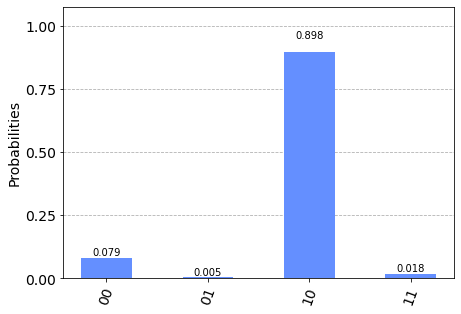

In [9]:
# Plotting our result
result = job.result()
plot_histogram(result.get_counts(qc))

As we see that there are a few results from the other three states when run in a real quantum computer. These are due to errors in the gates and qubit decoherence. We will learn more about these errors in later sections.

In [10]:
correct_results = result.get_counts(qc)[message]
accuracy = (correct_results/shots)*100
print(f"Accuracy = {accuracy:.2f}%")

Accuracy = 89.84%


In [ ]:
#Al igual que en la simulacion de teleportacion, en qiskit utilizamos 3 barreras. El msg tiene dos bits, por lo que las opciones
#seran 4. En este caso hemos enviado "10" porque asi lo hemos elegido, pero podrian haber sido cualquiera de los otros 3
#valores, y como estamos en un entorno real, a pesar de aplicar las puertas correctas, los reasultados nos arrojan un 10% de
#error, que no esta mal para ser un entorno real.